In [1]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i : (i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []

    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

Using TensorFlow backend.


In [0]:
# 1. 데이터셋 생성하기
signal_data = np.cos(np.arange(1600) * (20 * np.pi / 1000))[:, None]

# 데이터 전처리
scaler = MinMaxScaler(feature_range = (0, 1))
signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
train = signal_data[0:800]
val = signal_data[800:1200]
test = signal_data[1200:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
# 2. 모델 구성하기
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))

In [0]:
# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

In [6]:
# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()

for i in range(200):
    model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, verbose=2, callbacks=[custom_hist],
              validation_data=(x_val, y_val))
    model.reset_states()

Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 62s - loss: 0.1050 - val_loss: 0.0728
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 62s - loss: 0.0157 - val_loss: 0.0212
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0080 - val_loss: 0.0054
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0071 - val_loss: 0.0104
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0070 - val_loss: 0.0164
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0062 - val_loss: 0.0272
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0091 - val_loss: 0.0073
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0051 - val_loss: 0.0161
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0074 - val_loss: 0.0232
Train on 760 samples, validate on 360 samples
Epoch 1/1
 - 61s - loss: 0.0086 - val_loss: 0.0625
Train on 760 samples, validate

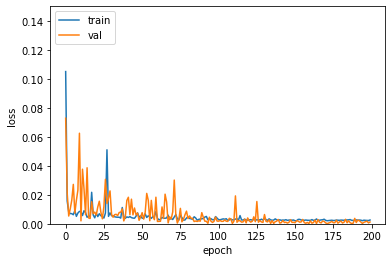

In [7]:
# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# 6. 모델 평가하기
trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
model.reset_states()
print('Train Score:', trainScore)
valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
model.reset_states()
print('Validataion Score:', valScore)
testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
model.reset_states()
print('Test Score:', testScore)

Train Score: 0.0013492337210022948
Validataion Score: 0.0012395676801521993
Test Score: 0.0012395676801521993


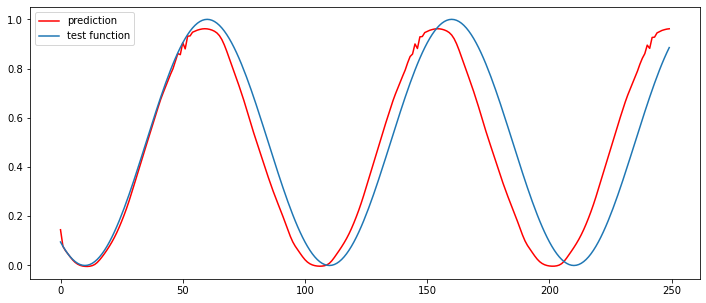

In [9]:
# 7. 모델 사용하기
look_ahead = 250
xhat = x_test[0]
predictions = np.zeros((look_ahead, 1))
for i in range(look_ahead):
    prediction = model.predict(np.array([xhat]), batch_size=1)
    predictions[i] = prediction
    xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), y_test[:look_ahead], label='test function')
plt.legend()
plt.show()